In [50]:
pip install catboost

In [51]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from imblearn.over_sampling import SMOTE
import joblib


# **Reading Data**

In [52]:
df= pd.read_csv('/content/Road_Collision_Vehicles_In_Camden_20240630.csv')

In [53]:
df.head()

,Collision ID,Borough Name,Collision Severity,Vehicle ID,Vehicle Type,Vehicle Type Banded,Vehicle Manoeuvres,Vehicle Skidding And Overturning,Vehicle Restricted Lane,Location Of Vehicle At First Impact,...,Northing,Longitude,Latitude,Ward Code,Ward Name,Spatial Accuracy,Location,Socrata ID,Last Uploaded,Organisation URI
0,1210295875,Camden,Slight,1,Car,Car,Going Ahead Other,No Skidding/Overturn,On Main CW - Not Rest.,Jct Mid,...,185555,-0.171805,51.554633,E05013659,Hampstead Town,Unknown,"(51.554633, -0.171805)",28730,27/06/2024 03:46:32 PM,http://opendatacommunities.org/id/london-borou...
1,1200249603,CAMDEN,NaN,1,01 PEDAL CYCLE,1 PEDAL CYCLE,99 UNKNOWN (S/R),9 UNKNOWN (S/R),99 UNKNOWN (S/R),9 UNKNOWN (S/R),...,184290,-0.141865,51.542787,E05013655,Camden Town,Unknown,"(51.542787, -0.141865)",20100,30/11/2022 10:44:46 AM,http://opendatacommunities.org/id/london-borou...
2,1210298634,Camden,Slight,2,GDS =< 3.5T,Goods Vehicle,Unknown (S/R),Unknown (S/R),Unknown (S/R),Leaving Main Rd,...,184575,-0.126309,51.545102,NaN,NaN,Unknown,"(51.545102, -0.126309)",28779,27/06/2024 03:46:32 PM,http://opendatacommunities.org/id/london-borou...
3,1200270949,CAMDEN,NaN,1,03 M/C 50-125CC,2 POWERED 2 WHEELER,99 UNKNOWN (S/R),9 UNKNOWN (S/R),99 UNKNOWN (S/R),0 NOT AT JCT,...,184573,-0.179812,51.545926,E05013670,South Hampstead,Unknown,"(51.545926, -0.179812)",20520,30/11/2022 10:44:46 AM,http://opendatacommunities.org/id/london-borou...
4,1200270666,CAMDEN,NaN,1,19 GDS =< 3.5T,7 GOODS VEHICLE,05 MOVING OFF,0 NO SKIDDING/OVERTURN,00 ON MAIN CW - NOT REST.,0 NOT AT JCT,...,185573,-0.208272,51.555357,E05013656,Fortune Green,Unknown,"(51.555357, -0.208272)",20508,30/11/2022 10:44:46 AM,http://opendatacommunities.org/id/london-borou...


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 48 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Collision ID                         11525 non-null  object 
 1   Borough Name                         11537 non-null  object 
 2   Collision Severity                   10431 non-null  object 
 3   Vehicle ID                           11537 non-null  int64  
 4   Vehicle Type                         11537 non-null  object 
 5   Vehicle Type Banded                  11537 non-null  object 
 6   Vehicle Manoeuvres                   11537 non-null  object 
 7   Vehicle Skidding And Overturning     11537 non-null  object 
 8   Vehicle Restricted Lane              11537 non-null  object 
 9   Location Of Vehicle At First Impact  11537 non-null  object 
 10  Vehicle Hit Object In Carriageway    10022 non-null  object 
 11  Vehicle Leaving Carriageway 

# **Data Cleaning**

**1. Converting values of all columns in lower case so that values having different cases should be considered as one.**

In [55]:
# Convert all string values in the DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

<ipython-input-55-c202facc936a>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


**2. Checking unique value counts for target Variable.**

In [56]:
df['Collision Severity'] = df['Collision Severity']
counts = df['Collision Severity'].value_counts()

print(counts)
#there are 1106 records not having values of target variable- so I am removing those records.

Collision Severity
3 slight     6890
slight       2243
2 serious     897
serious       368
1 fatal        25
fatal           8
Name: count, dtype: int64


In [57]:
df.shape

(11537, 48)

**3. Using only last three years data from maximum date available (since data source says so).**

In [58]:
# Find the minimum and maximum values of the 'date' column
#Source asks to use only last three years data.
df['Collision Date'] = pd.to_datetime(df['Collision Date'], format="%d/%m/%Y %I:%M:%S %p", dayfirst=True)

min_date = df['Collision Date'].min()
max_date = df['Collision Date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2015-01-01 02:15:00
Maximum date: 2022-12-31 04:40:00


In [59]:
# Calculate the start date for the 3-year period
start_date = max_date - pd.DateOffset(years=3)

# Filter the DataFrame to include only the last 3 years of data
df = df[df['Collision Date'] >= start_date]

print(df.shape)

(2626, 48)


**4. Analysing unique values of each column and dropping less useful columns**

In [60]:
# Drop records where 'Collision Severity' column is NaN
df = df.dropna(subset=['Collision Severity'])

#Removing less useful columns
#CollisionID- looks reference number, should be dropped.
#Borough Name- just one unique value- Camden, so can be dropped.
#Vehicle Type- Vehicle Type Banded gives more detailed information than vehicle type. So, vehicle type can be dropped.

df.drop(columns=['Collision ID', 'Borough Name', 'Vehicle Type', 'Last Uploaded', 'Organisation URI',
                 'Socrata ID']
        , inplace=True)
print(df.shape)

(2626, 42)


In [61]:
# Get unique values for each column
unique_values = {column: df[column].unique() for column in df.columns}

print(unique_values)

{'Collision Severity': array(['slight', '3 slight', 'serious', 'fatal'], dtype=object), 'Vehicle ID': array([1, 2, 3, 5, 4]), 'Vehicle Type Banded': array(['car', 'goods vehicle', 'pedal cycle', 'powered 2 wheeler',
       '2 powered 2 wheeler', 'bus or coach', 'other vehicle',
       'private hire', 'taxi', '3 car'], dtype=object), 'Vehicle Manoeuvres': array(['going ahead other', 'unknown (s/r)', 'moving off',
       'going ahead held up', 'turning right', 'overtake move veh o/s',
       '11 change lane to left', 'turning left', 'reversing',
       'overtaking nearside', 'change lane to right',
       'waiting to turn left', 'going ahead right bend',
       'slowing or stopping', 'u-turning', 'going ahead left bend',
       'parked', 'overtake stat veh o/s', '05 moving off',
       'change lane to left', 'waiting to turn right', '09 turning right',
       '99 unknown (s/r)', '18 going ahead other'], dtype=object), 'Vehicle Skidding And Overturning': array(['no skidding/overturn', 'un

In [62]:
#Vehicle Manoeuvres- Vehicle Skidding And Overturning gives more cleaned information than Manoeuvres.
#Driver Age- Driver Age Band is more useful to use.
#Location attributes can be dropped-Easting, Northing, Latitude, Longitude, Ward Code ,Spatial Accuracy

df.drop(columns=['Vehicle Manoeuvres', 'Driver Age', 'Easting', 'Northing',
                 'Longitude', 'Latitude', 'Spatial Accuracy', 'Ward Code', 'Location']
        , inplace=True)
print(df.shape)

(2626, 33)


In [63]:
df.head()

,Collision Severity,Vehicle ID,Vehicle Type Banded,Vehicle Skidding And Overturning,Vehicle Restricted Lane,Location Of Vehicle At First Impact,Vehicle Hit Object In Carriageway,Vehicle Leaving Carriageway,Vehicle Hit Object Off Carriageway,First Point Of Impact,...,Junction Control,Second Road Class,Second Road Number,Pedestrian Crossing Facilities,Light Conditions,Weather Details,Road Surface Condition,Special Conditions At Site,Carriageway Hazards,Ward Name
0,slight,1,car,no skidding/overturn,on main cw - not rest.,jct mid,NaN,did not leave,NaN,front hit first,...,give way/uncontrolled,unclassified,0.0,zebra,daylight,fine,road-dry,NaN,NaN,hampstead town
2,slight,2,goods vehicle,unknown (s/r),unknown (s/r),leaving main rd,unknown (s/r),unknown (s/r),unknown (s/r),unknown (s/r),...,give way/uncontrolled,unclassified,0.0,unknown (s/r),daylight,fine,road-dry,NaN,NaN,NaN
30,slight,2,pedal cycle,no skidding/overturn,footway,jct mid,NaN,did not leave,NaN,front hit first,...,give way/uncontrolled,unclassified,0.0,no xing facility in 50m,daylight,fine,road-dry,NaN,NaN,fortune green
46,slight,1,car,no skidding/overturn,on main cw - not rest.,jct app,NaN,did not leave,NaN,back hit first,...,auto sig,unclassified,0.0,zebra,daylight,fine,road-dry,NaN,NaN,south hampstead
55,slight,1,car,no skidding/overturn,on main cw - not rest.,jct app,NaN,did not leave,NaN,front hit first,...,auto sig,a,598.0,zebra,daylight,unknown,road-dry,NaN,NaN,NaN


**6. Further cleaning- Removing numeric digits from some string values**

In [64]:
# Function to remove numeric prefixes
def remove_numeric_prefix(s):
    if isinstance(s, str):
        return re.sub(r'^\d+\s*', '', s)
    return s

In [65]:
# Identify string columns
string_columns = df.select_dtypes(include=['object']).columns

# Columns to exclude
exclude_columns = ['Driver Age Band', 'Speed Limit']

# Columns to apply the function to
apply_columns = [col for col in string_columns if col not in exclude_columns]

# Apply the function to the selected columns
df[apply_columns] = df[apply_columns].applymap(remove_numeric_prefix)

<ipython-input-65-148121306545>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[apply_columns] = df[apply_columns].applymap(remove_numeric_prefix)


In [66]:
# Get unique values for each column
#Checking if data is cleaned
unique_values = {column: df[column].unique() for column in df.select_dtypes(include=['object']).columns}

print(unique_values)

{'Collision Severity': array(['slight', 'serious', 'fatal'], dtype=object), 'Vehicle Type Banded': array(['car', 'goods vehicle', 'pedal cycle', 'powered 2 wheeler',
       'bus or coach', 'other vehicle', 'private hire', 'taxi'],
      dtype=object), 'Vehicle Skidding And Overturning': array(['no skidding/overturn', 'unknown (s/r)', 'skidded', 'overturn',
       'skid/over'], dtype=object), 'Vehicle Restricted Lane': array(['on main cw - not rest.', 'unknown (s/r)', 'footway',
       'lay-by/hard shldr', 'bus lane', 'cycle lane (on cwy)',
       'entering lay-by/hard shldr', 'cycleway/footway (separated)'],
      dtype=object), 'Location Of Vehicle At First Impact': array(['jct mid', 'leaving main rd', 'jct app', 'unknown (s/r)',
       'jct cleared', 'not at jct', 'entering main rd', "leaving r'about",
       "entering r'about", 'entering from slip'], dtype=object), 'Vehicle Hit Object In Carriageway': array([nan, 'unknown (s/r)', 'hit kerb', 'none', 'hit open door',
       'hit park

**7. Treating Null Values**

In [67]:
# Get the count of null values for each column
null_counts = df.isnull().sum()

print("Count of null values for each column:")
print(null_counts)

Count of null values for each column:
Collision Severity                        0
Vehicle ID                                0
Vehicle Type Banded                       0
Vehicle Skidding And Overturning          0
Vehicle Restricted Lane                   0
Location Of Vehicle At First Impact       0
Vehicle Hit Object In Carriageway      1503
Vehicle Leaving Carriageway               0
Vehicle Hit Object Off Carriageway     1614
First Point Of Impact                     0
Driver Gender                             0
Driver Age Band                           0
Collision Location                        0
Casualty Count                            0
Collision Date                            0
Day Name                                  0
Time                                      0
Highway Authority                         0
First Road Class                          0
First Road Number                         0
Road Type                                 0
Speed Limit                           

In [68]:
#Filling null values with unknown (s/r) as it is present in majority of columns
df = df.fillna("unknown (s/r)")

**8. Handling categorical values**

In [69]:
#Storing all categorical columns in one variable
categorical_columns = df.select_dtypes(include=['object']).columns

In [70]:
categorical_columns

Index(['Collision Severity', 'Vehicle Type Banded',
       'Vehicle Skidding And Overturning', 'Vehicle Restricted Lane',
       'Location Of Vehicle At First Impact',
       'Vehicle Hit Object In Carriageway', 'Vehicle Leaving Carriageway',
       'Vehicle Hit Object Off Carriageway', 'First Point Of Impact',
       'Driver Gender', 'Driver Age Band', 'Collision Location', 'Day Name',
       'Highway Authority', 'First Road Class', 'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 'Second Road Class',
       'Pedestrian Crossing Facilities', 'Light Conditions', 'Weather Details',
       'Road Surface Condition', 'Special Conditions At Site',
       'Carriageway Hazards', 'Ward Name'],
      dtype='object')

In [71]:
# Replace empty strings in 'Second Road Class' with 'unclassified'
df['Second Road Class'] = df['Second Road Class'].replace('', 'unclassified')

In [72]:
#Get count of unique values for each categorical column
categorical_counts = {column: df[column].value_counts() for column in categorical_columns}

#counts for each categorical column
for column, counts in categorical_counts.items():
    print(f"Counts for column '{column}':")
    print(counts)
    print()

Counts for column 'Collision Severity':
Collision Severity
slight     2250
serious     368
fatal         8
Name: count, dtype: int64

Counts for column 'Vehicle Type Banded':
Vehicle Type Banded
car                  1047
pedal cycle           569
powered 2 wheeler     493
goods vehicle         220
taxi                  105
private hire           69
other vehicle          63
bus or coach           60
Name: count, dtype: int64

Counts for column 'Vehicle Skidding And Overturning':
Vehicle Skidding And Overturning
no skidding/overturn    1500
unknown (s/r)            968
skidded                   75
overturn                  55
skid/over                 28
Name: count, dtype: int64

Counts for column 'Vehicle Restricted Lane':
Vehicle Restricted Lane
on main cw - not rest.          1520
unknown (s/r)                    973
cycle lane (on cwy)               57
bus lane                          44
footway                           22
lay-by/hard shldr                  7
entering lay-by/hard

# **Data Visualization**

**1. Distribution of Collision Severity**

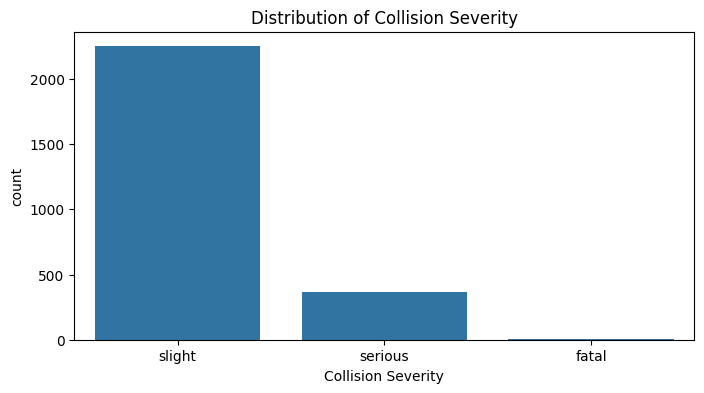

In [73]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Collision Severity')
plt.title('Distribution of Collision Severity')
plt.show()

**2. Distribution of Collision Severity by Different Categorical Features**

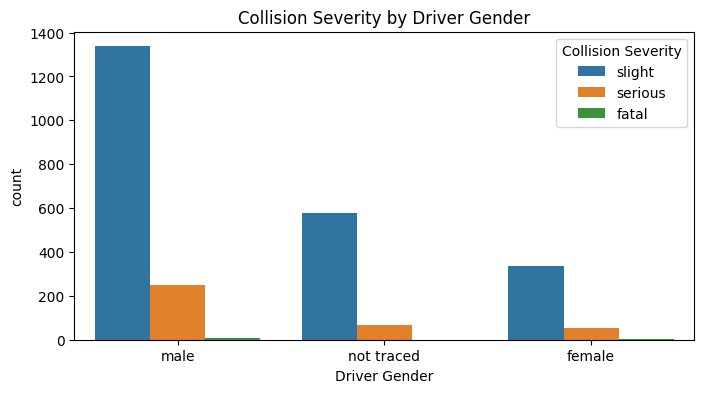

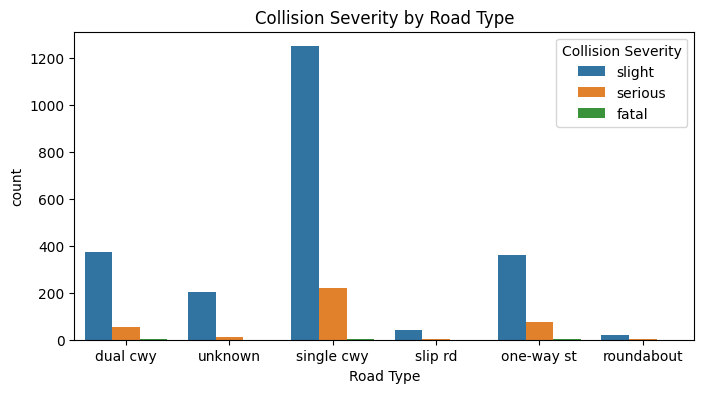

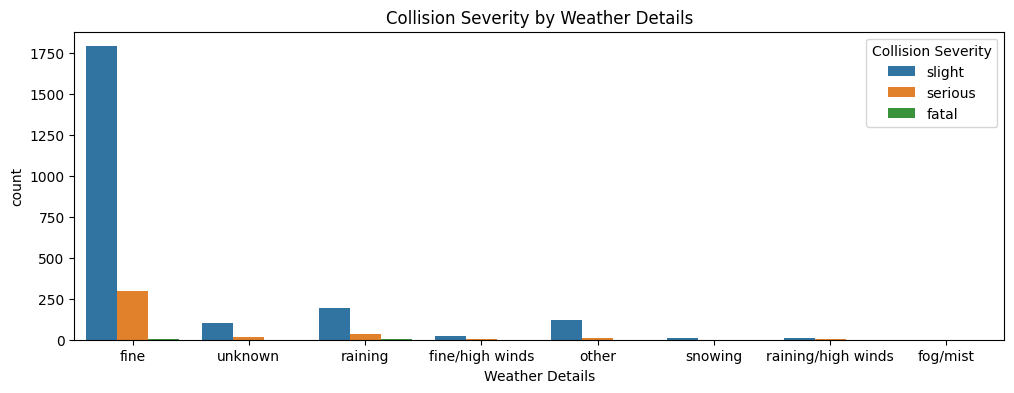

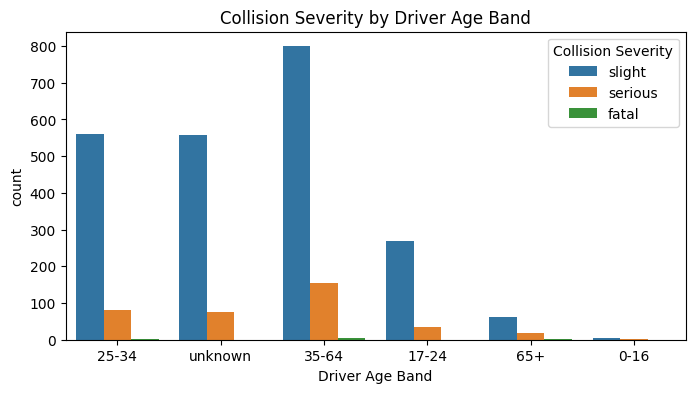

In [74]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Driver Gender', hue='Collision Severity')
plt.title('Collision Severity by Driver Gender')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Road Type', hue='Collision Severity')
plt.title('Collision Severity by Road Type')
plt.show()

plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='Weather Details', hue='Collision Severity')
plt.title('Collision Severity by Weather Details')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Driver Age Band', hue='Collision Severity')
plt.title('Collision Severity by Driver Age Band')
plt.show()

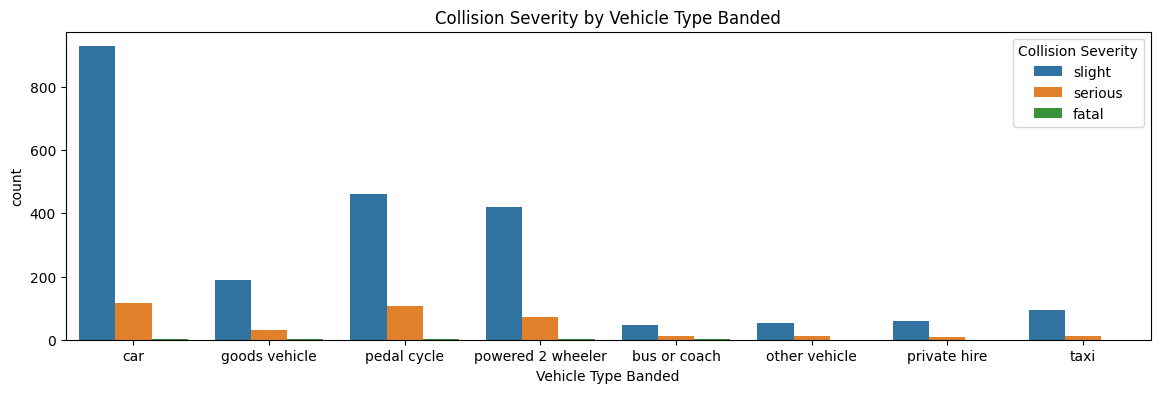

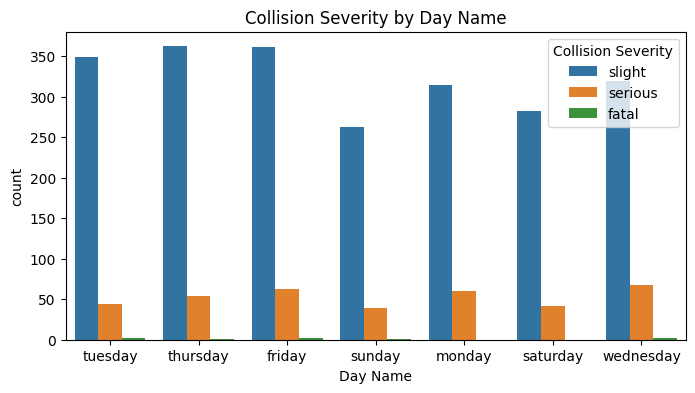

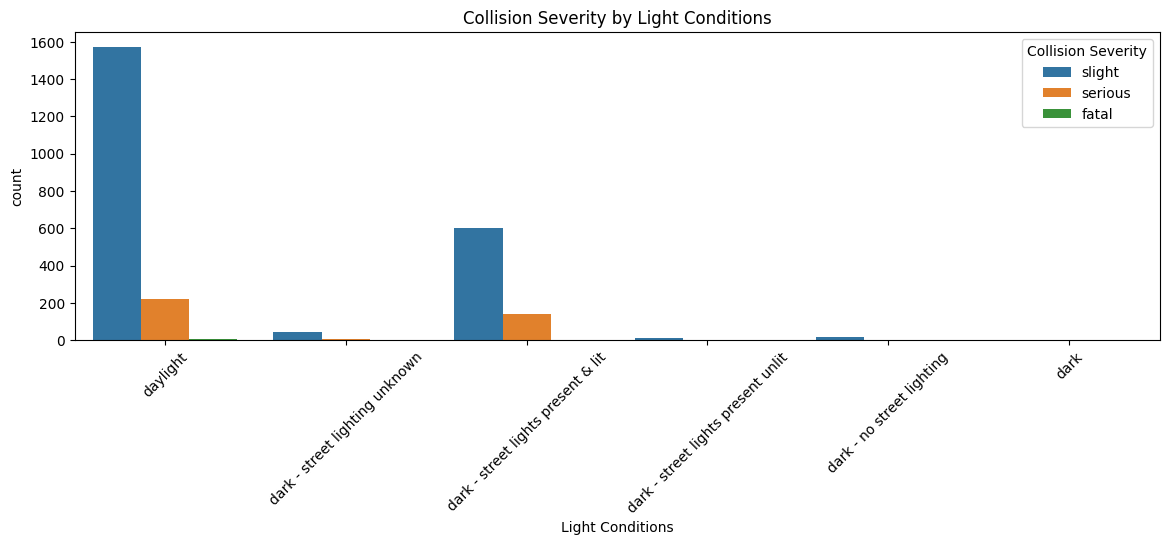

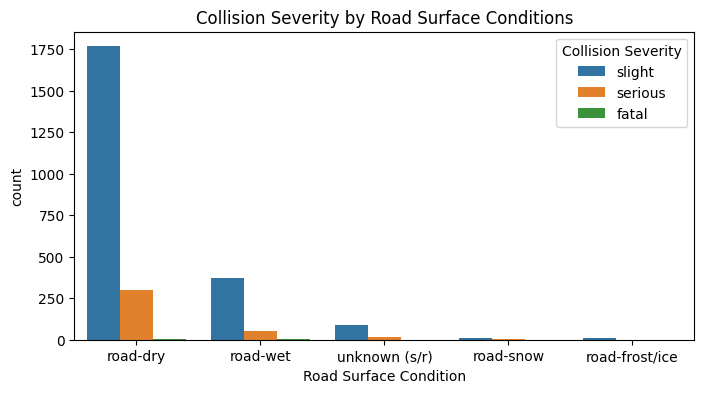

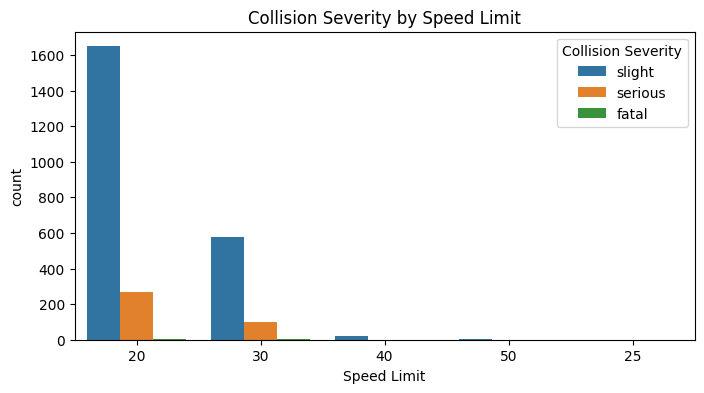

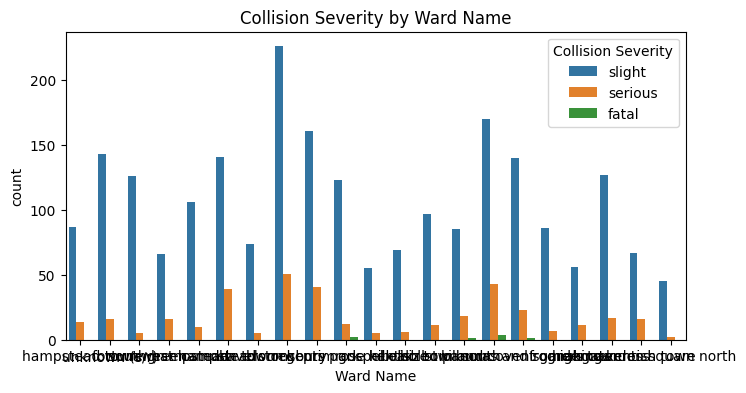

In [77]:
plt.figure(figsize=(14, 4))
sns.countplot(data=df, x='Vehicle Type Banded', hue='Collision Severity')
plt.title('Collision Severity by Vehicle Type Banded')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Day Name', hue='Collision Severity')
plt.title('Collision Severity by Day Name')
plt.show()

plt.figure(figsize=(14, 4))
sns.countplot(data=df, x='Light Conditions', hue='Collision Severity')
plt.title('Collision Severity by Light Conditions')
plt.xticks(rotation= 45)
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Road Surface Condition', hue='Collision Severity')
plt.title('Collision Severity by Road Surface Conditions')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Speed Limit', hue='Collision Severity')
plt.title('Collision Severity by Speed Limit')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Ward Name', hue='Collision Severity')
plt.title('Collision Severity by Ward Name')
plt.show()

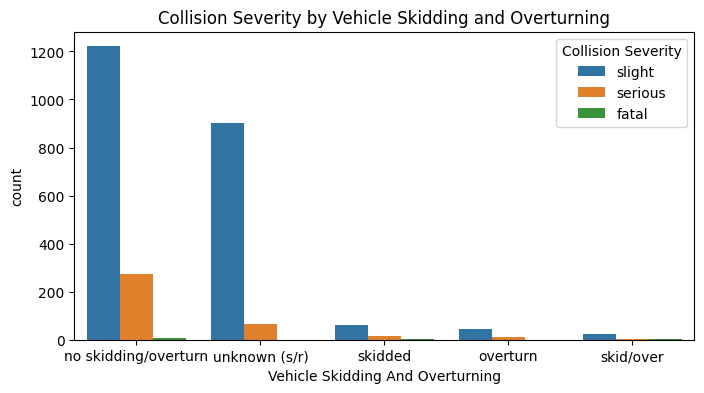

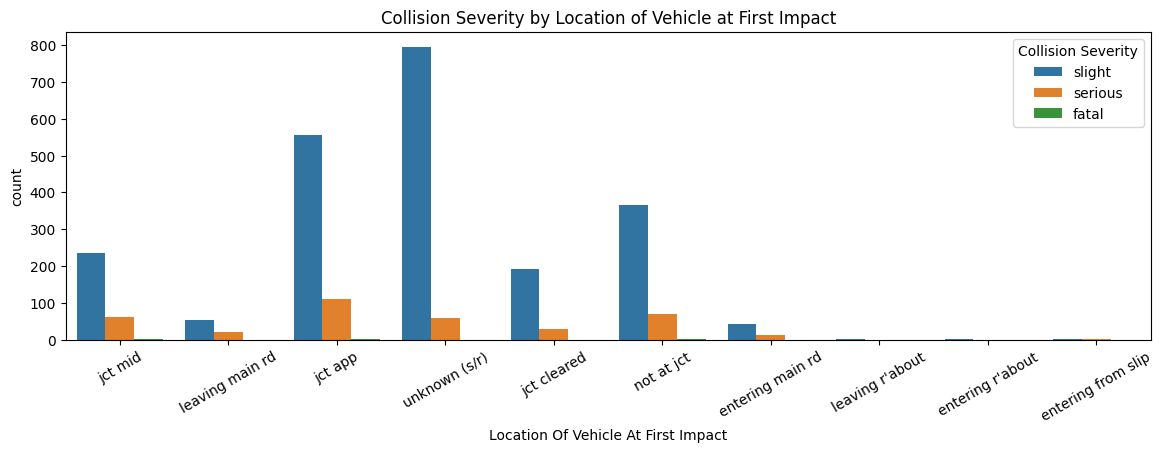

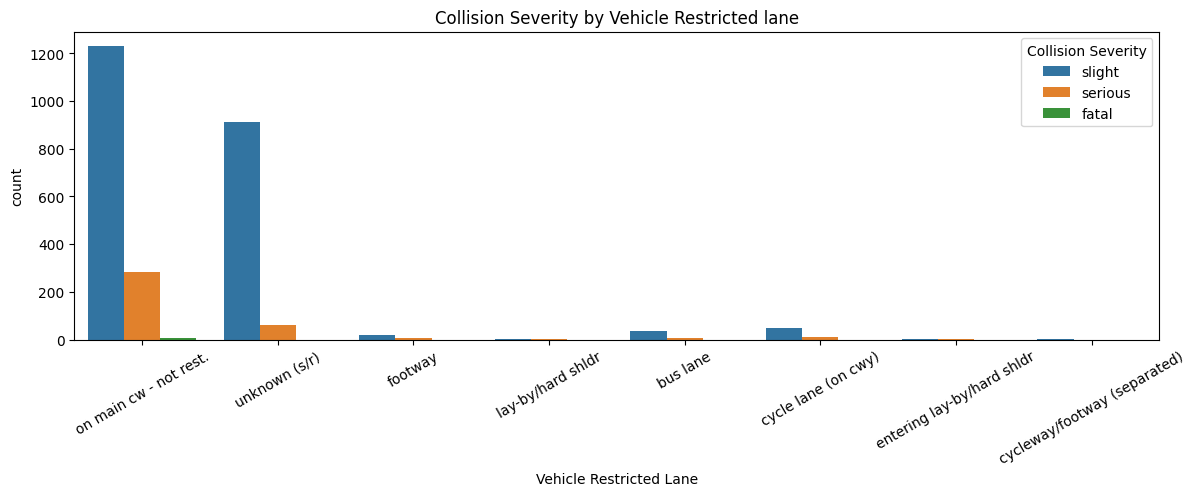

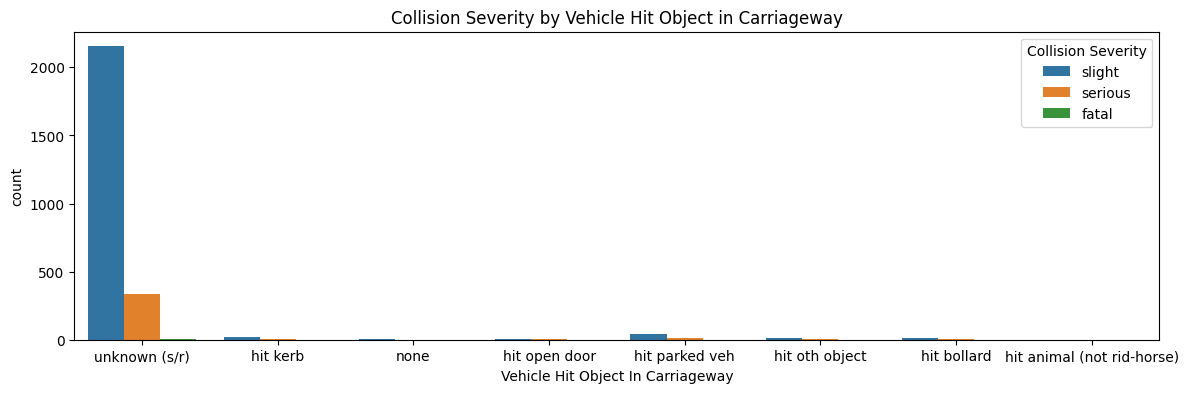

In [79]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Vehicle Skidding And Overturning', hue='Collision Severity')
plt.title('Collision Severity by Vehicle Skidding and Overturning')
plt.show()

plt.figure(figsize=(14, 4))
sns.countplot(data=df, x='Location Of Vehicle At First Impact', hue='Collision Severity')
plt.title('Collision Severity by Location of Vehicle at First Impact')
plt.xticks(rotation= 30)
plt.show()

plt.figure(figsize=(14, 4))
sns.countplot(data=df, x='Vehicle Restricted Lane', hue='Collision Severity')
plt.title('Collision Severity by Vehicle Restricted lane')
plt.xticks(rotation= 30)
plt.show()

plt.figure(figsize=(14, 4))
sns.countplot(data=df, x='Vehicle Hit Object In Carriageway', hue='Collision Severity')
plt.title('Collision Severity by Vehicle Hit Object in Carriageway')
plt.show()

**3. Time Series Analysis**

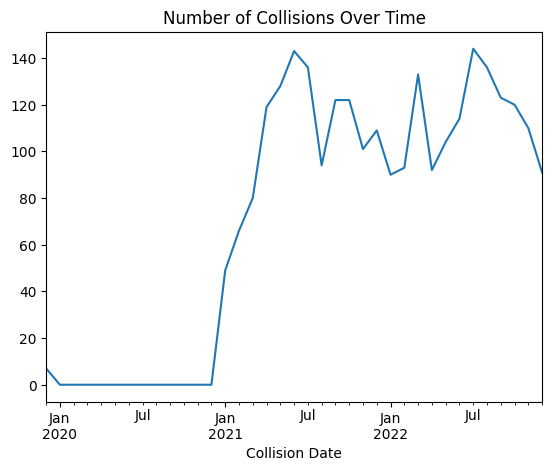

In [ ]:
df['Collision Date'] = pd.to_datetime(df['Collision Date'])
df.set_index('Collision Date', inplace=True)
df['Collision Severity'].resample('M').count().plot()
plt.title('Number of Collisions Over Time')
plt.show()
df.reset_index(inplace=True)  # Reset index for further operations

**Label Encoding**

In [ ]:
# Label Encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

    # Check the class-to-label mapping
    print(f"Column: {column}")
    class_mapping = dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_)))
    print(class_mapping)
    print()


Column: Collision Severity
{'fatal': 0, 'serious': 1, 'slight': 2}

Column: Vehicle Type Banded
{'bus or coach': 0, 'car': 1, 'goods vehicle': 2, 'other vehicle': 3, 'pedal cycle': 4, 'powered 2 wheeler': 5, 'private hire': 6, 'taxi': 7}

Column: Vehicle Skidding And Overturning
{'no skidding/overturn': 0, 'overturn': 1, 'skid/over': 2, 'skidded': 3, 'unknown (s/r)': 4}

Column: Vehicle Restricted Lane
{'bus lane': 0, 'cycle lane (on cwy)': 1, 'cycleway/footway (separated)': 2, 'entering lay-by/hard shldr': 3, 'footway': 4, 'lay-by/hard shldr': 5, 'on main cw - not rest.': 6, 'unknown (s/r)': 7}

Column: Location Of Vehicle At First Impact
{'entering from slip': 0, 'entering main rd': 1, "entering r'about": 2, 'jct app': 3, 'jct cleared': 4, 'jct mid': 5, 'leaving main rd': 6, "leaving r'about": 7, 'not at jct': 8, 'unknown (s/r)': 9}

Column: Vehicle Hit Object In Carriageway
{'hit animal (not rid-horse)': 0, 'hit bollard': 1, 'hit kerb': 2, 'hit open door': 3, 'hit oth object': 4, 'h

In [ ]:
print("Label Encoded DataFrame:")
df.head()

Label Encoded DataFrame:


,Collision Date,Collision Severity,Vehicle ID,Vehicle Type Banded,Vehicle Skidding And Overturning,Vehicle Restricted Lane,Location Of Vehicle At First Impact,Vehicle Hit Object In Carriageway,Vehicle Leaving Carriageway,Vehicle Hit Object Off Carriageway,...,Junction Control,Second Road Class,Second Road Number,Pedestrian Crossing Facilities,Light Conditions,Weather Details,Road Surface Condition,Special Conditions At Site,Carriageway Hazards,Ward Name
0,2021-03-09 07:35:00,2,1,1,0,6,5,7,0,8,...,2,3,0.0,6,5,0,0,8,5,7
1,2021-03-25 08:40:00,2,2,2,4,7,6,7,8,8,...,2,3,0.0,5,5,0,0,8,5,19
2,2022-10-14 15:15:00,2,2,4,0,4,5,7,0,8,...,2,3,0.0,2,5,0,0,8,5,4
3,2021-10-03 08:20:00,2,1,1,0,6,3,7,0,8,...,1,3,0.0,6,5,0,0,8,5,17
4,2021-02-23 08:50:00,2,1,1,0,6,3,7,0,8,...,1,0,598.0,6,5,7,0,8,5,19


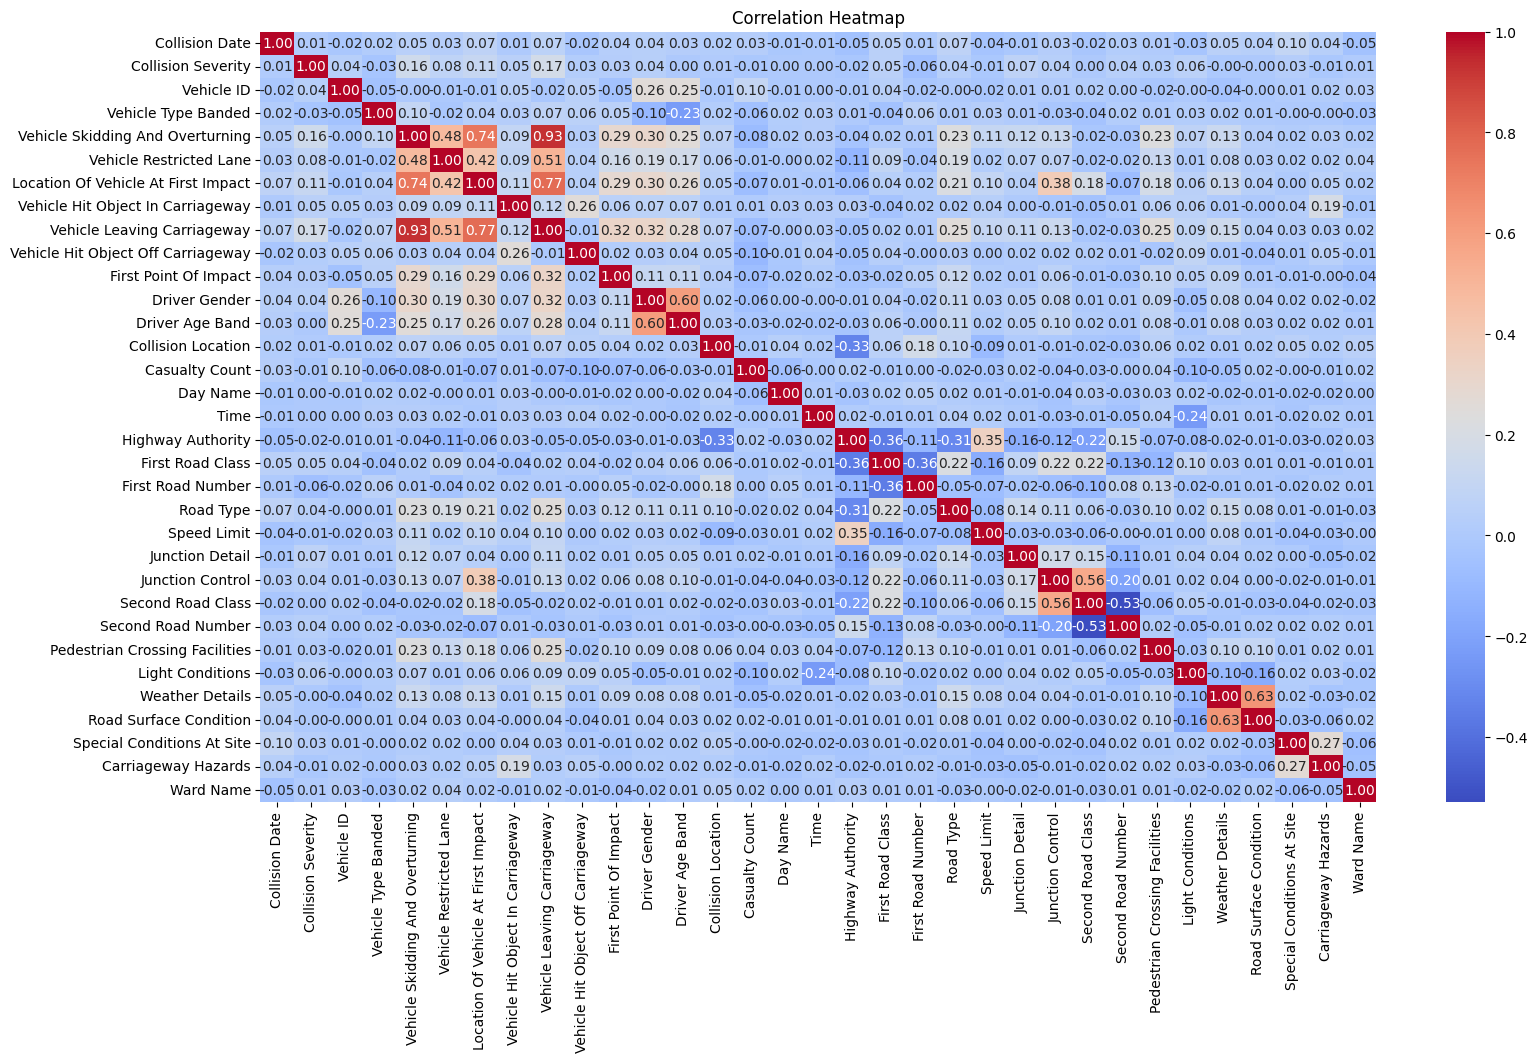

In [ ]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Columns that can be dropped-**
Collision Date,
Vehicle ID (not accurate information),
Driver Age Band,
Collision Location,
Day Name,
Time,
Second Road Class

**Important columns**- Vehicle Skidding and Overturning,
Location of Vehicle at First Impact,
Vehicle Leaving Carriageaway,
Light Conditions

In [ ]:
#Columns to drop
columns_to_drop = ['Collision Date', 'Vehicle ID', 'Driver Age Band', 'Collision Location', 'Day Name', 'Time', 'Second Road Class', 'Ward Name']

#Drop the specified columns
df = df.drop(columns=columns_to_drop)

print(df.shape)

(2626, 25)


In [ ]:
df.head()

,Collision Severity,Vehicle Type Banded,Vehicle Skidding And Overturning,Vehicle Restricted Lane,Location Of Vehicle At First Impact,Vehicle Hit Object In Carriageway,Vehicle Leaving Carriageway,Vehicle Hit Object Off Carriageway,First Point Of Impact,Driver Gender,...,Speed Limit,Junction Detail,Junction Control,Second Road Number,Pedestrian Crossing Facilities,Light Conditions,Weather Details,Road Surface Condition,Special Conditions At Site,Carriageway Hazards
0,2,1,0,6,5,7,0,8,2,1,...,0,0,2,0.0,6,5,0,0,8,5
1,2,2,4,7,6,7,8,8,5,2,...,2,2,2,0.0,5,5,0,0,8,5
2,2,4,0,4,5,7,0,8,2,1,...,2,5,2,0.0,2,5,0,0,8,5
3,2,1,0,6,3,7,0,8,0,0,...,2,9,1,0.0,6,5,0,0,8,5
4,2,1,0,6,3,7,0,8,2,0,...,2,5,1,598.0,6,5,7,0,8,5


**Balancing Target Class Distribution using SMOTE technique**

In [ ]:
target_counts = df['Collision Severity'].value_counts()

print("Count of each class in the target variable:")
print(target_counts)

Count of each class in the target variable:
Collision Severity
2    2250
1     368
0       8
Name: count, dtype: int64


Balancing an imbalanced dataset can be crucial for improving the performance of machine learning models.

In [ ]:
X = df.drop(columns=['Collision Severity'])
y = df['Collision Severity']

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
#Print the count of each class after resampling
resampled_counts = pd.Series(y_resampled).value_counts()
print("Count of each class after resampling:")
print(resampled_counts)
print()

Count of each class after resampling:
Collision Severity
2    2250
1    2250
0    2250
Name: count, dtype: int64



**Split the resampled data into training and testing sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# **Classifiers Implementation**

In [ ]:
classifiers = {
'Random Forest': RandomForestClassifier(random_state=42),
'Decision Tree': DecisionTreeClassifier(random_state=42),
'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

Accuracy for Random Forest: 0.9496
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       658
           1       0.91      0.94      0.92       658
           2       0.94      0.91      0.93       709

    accuracy                           0.95      2025
   macro avg       0.95      0.95      0.95      2025
weighted avg       0.95      0.95      0.95      2025

Confusion Matrix for Random Forest:


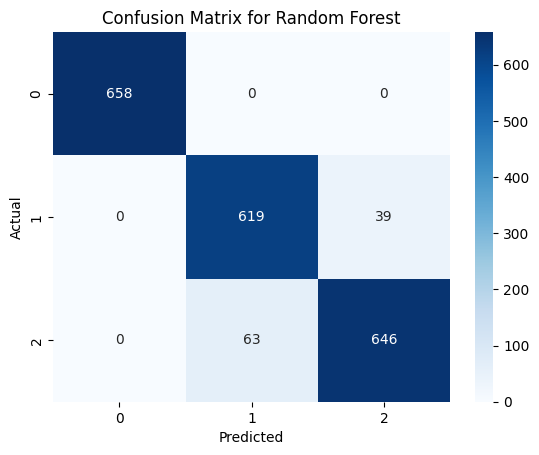

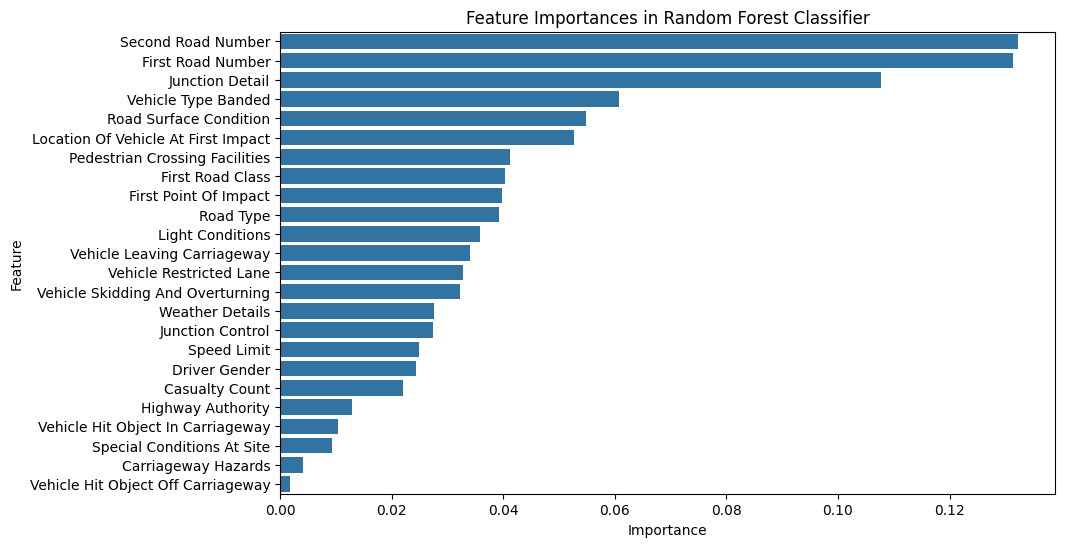

Feature Importances:
                                Feature  Importance
17                   Second Road Number    0.132290
12                    First Road Number    0.131363
15                      Junction Detail    0.107624
0                   Vehicle Type Banded    0.060677
21               Road Surface Condition    0.054853
3   Location Of Vehicle At First Impact    0.052629
18       Pedestrian Crossing Facilities    0.041292
11                     First Road Class    0.040393
7                 First Point Of Impact    0.039765
13                            Road Type    0.039247
19                     Light Conditions    0.035904
5           Vehicle Leaving Carriageway    0.034104
2               Vehicle Restricted Lane    0.032868
1      Vehicle Skidding And Overturning    0.032317
20                      Weather Details    0.027666
16                     Junction Control    0.027336
14                          Speed Limit    0.024838
8                         Driver Gender    

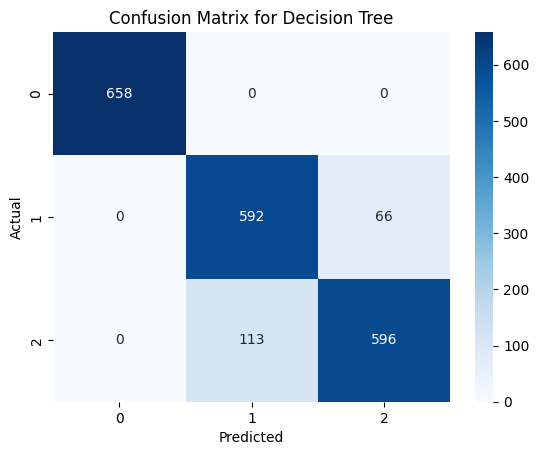

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:45:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for XGBoost: 0.9402
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       658
           1       0.90      0.93      0.91       658
           2       0.93      0.89      0.91       709

    accuracy                           0.94      2025
   macro avg       0.94      0.94      0.94      2025
weighted avg       0.94      0.94      0.94      2025

Confusion Matrix for XGBoost:


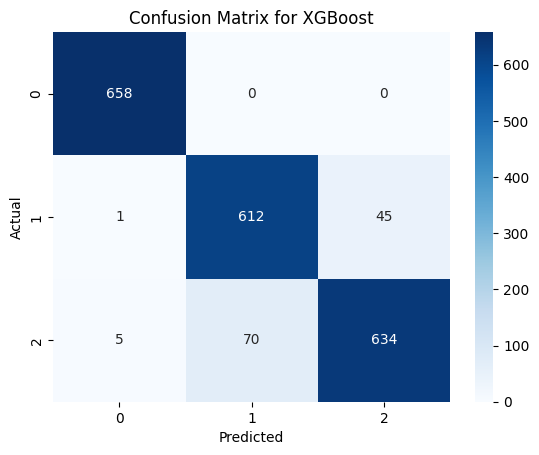

Accuracy for CatBoost: 0.9402
Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       658
           1       0.89      0.93      0.91       658
           2       0.94      0.89      0.91       709

    accuracy                           0.94      2025
   macro avg       0.94      0.94      0.94      2025
weighted avg       0.94      0.94      0.94      2025

Confusion Matrix for CatBoost:


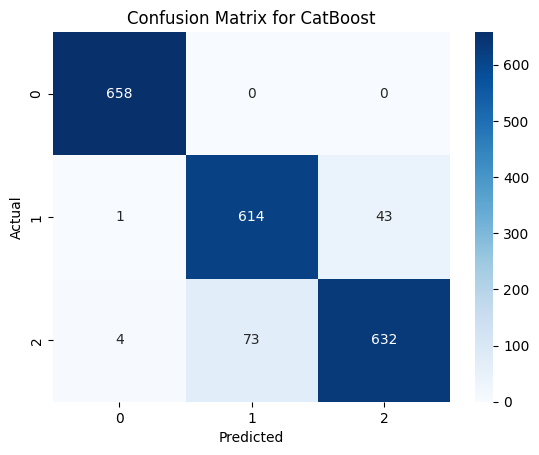

Best model (Random Forest) saved with accuracy: 0.9496


In [ ]:
# Variable to store the best model and its accuracy
best_model = None
best_accuracy = 0
best_model_name = ''

for name, clf in classifiers.items():
  # Train the classifier
  clf.fit(X_train, y_train)

  # Predict the target variable
  y_pred = clf.predict(X_test)
  y_pred_proba = clf.predict_proba(X_test)[:, 1]

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for {name}: {accuracy:.4f}")

  # Check if this is the best model
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = clf
    best_model_name = name

  # Classification report
  print(f"Classification Report for {name}:")
  print(classification_report(y_test, y_pred))

  # Confusion matrix
  print(f"Confusion Matrix for {name}:")
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix for {name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # Feature importances for Random Forest
  if name == 'Random Forest':
      feature_importances = clf.feature_importances_
      features = X.columns

      # Create a DataFrame for feature importances
      importance_df = pd.DataFrame({
          'Feature': features,
          'Importance': feature_importances
      })

      # Sort the DataFrame by importance
      importance_df = importance_df.sort_values(by='Importance', ascending=False)

      # Plot feature importances
      plt.figure(figsize=(10, 6))
      sns.barplot(x='Importance', y='Feature', data=importance_df)
      plt.title('Feature Importances in Random Forest Classifier')
      plt.xlabel('Importance')
      plt.ylabel('Feature')
      plt.show()

      # Print the feature importances
      print("Feature Importances:")
      print(importance_df)
      print()

# Save the best model
if best_model:
    joblib.dump(best_model, f'best_model_{best_model_name}.joblib')
    print(f"Best model ({best_model_name}) saved with accuracy: {best_accuracy:.4f}")

In [ ]:
X_test.head()

,Vehicle Type Banded,Vehicle Skidding And Overturning,Vehicle Restricted Lane,Location Of Vehicle At First Impact,Vehicle Hit Object In Carriageway,Vehicle Leaving Carriageway,Vehicle Hit Object Off Carriageway,First Point Of Impact,Driver Gender,Casualty Count,...,Speed Limit,Junction Detail,Junction Control,Second Road Number,Pedestrian Crossing Facilities,Light Conditions,Weather Details,Road Surface Condition,Special Conditions At Site,Carriageway Hazards
6267,3,4,7,9,7,8,8,4,0,1.0,...,1,9,2,0.0,6,5,3,0,8,5
5403,2,1,2,3,7,0,8,4,0,1.0,...,0,9,2,0.0,6,5,0,0,8,5
4995,1,0,4,8,5,0,8,2,2,1.0,...,0,4,4,0.0,2,5,0,0,8,5
2465,1,4,7,9,7,8,8,5,1,4.0,...,2,10,5,5.0,5,3,3,0,8,5
2348,5,0,6,5,7,3,8,4,1,1.0,...,2,3,2,41.0,3,3,0,0,8,5
